Импортируем все необходимые нам библотеки.

In [ ]:
import pickle
import numpy as np
import pandas as pd
import torch
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision import models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Фиксируем все случайные последовательнсоти

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Определяем типы датасетов, размер изображений для обработыки и девайс.

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

Используем дата враппер из ноутбука на колабе.

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        # если выборка для тренировки сети, проводим аугментацию
        else:
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomChoice(
                                  [transforms.ColorJitter(0.5, 0.5),
                                  transforms.RandomPerspective(),
                                  transforms.RandomGrayscale(),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(180)]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

В данном шаге мы размножаем малочисленные классы (правда, неизвестно поможет нам это на тестовой выборке или же нет, поскольку скор который дает данный подход достигался мной и без данного шага, но с большим колличетсвом эпох)

In [ ]:
import os
import shutil

TRAIN_DIR = Path('/kaggle/input/simpsons4/train/simpsons_dataset/')
TEST_DIR = Path('/kaggle/input/simpsons4/testset/testset')

shutil.copytree(TRAIN_DIR, '/kaggle/working/simpsons_dataset')
TRAIN_DIR = Path('/kaggle/working/simpsons_dataset')

folders = ([name for name in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, name))])

for folder in folders:
    contents = os.listdir(os.path.join(TRAIN_DIR,folder))
    while len(contents) < 500:
        i = 1
        for file in contents:
            base, extension = os.path.splitext(file)
            new_file = os.path.join(TRAIN_DIR,folder, base + str(i) + extension)
            shutil.copy(os.path.join(TRAIN_DIR,folder, file), os.path.join(TRAIN_DIR,folder, new_file))
        i += 1
        contents = os.listdir(os.path.join(TRAIN_DIR,folder))
        print(folder, len(contents))

              
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

cletus_spuckler 94
cletus_spuckler 141
cletus_spuckler 188
cletus_spuckler 235
cletus_spuckler 282
cletus_spuckler 329
cletus_spuckler 376
cletus_spuckler 423
cletus_spuckler 470
cletus_spuckler 517
patty_bouvier 144
patty_bouvier 216
patty_bouvier 288
patty_bouvier 360
patty_bouvier 432
patty_bouvier 504
kent_brockman 996
gil 54
gil 81
gil 108
gil 135
gil 162
gil 189
gil 216
gil 243
gil 270
gil 297
gil 324
gil 351
gil 378
gil 405
gil 432
gil 459
gil 486
gil 513
martin_prince 142
martin_prince 213
martin_prince 284
martin_prince 355
martin_prince 426
martin_prince 497
martin_prince 568
waylon_smithers 362
waylon_smithers 543
snake_jailbird 110
snake_jailbird 165
snake_jailbird 220
snake_jailbird 275
snake_jailbird 330
snake_jailbird 385
snake_jailbird 440
snake_jailbird 495
snake_jailbird 550
professor_john_frink 130
professor_john_frink 195
professor_john_frink 260
professor_john_frink 325
professor_john_frink 390
professor_john_frink 455
professor_john_frink 520
miss_hoover 34
miss_h

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Просморт примеров из датасета (можно удалить данный шаг)

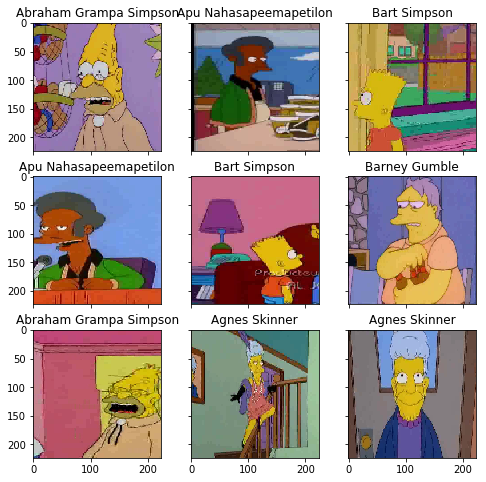

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Функции для Train из колаба

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # заменяем исходный lr, добавляем scheduler
        opt = torch.optim.Adam(model.parameters(), lr=0.0001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size = 14, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
print("We will classify {} classes".format(n_classes))

We will classify 42 classes


Определяем наши датасеты

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

**Исходную архитекуру мы заменяем на Transfer Learning**

В данной случае используем Pretreined Resnet18, ничего не морозим

In [ ]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)
model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 109MB/s] 


Запускаем обучение сети

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=30, batch_size=32)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.704124656218801


epoch:   3%|▎         | 1/30 [04:26<2:08:48, 266.51s/it]


Epoch 001 train_loss: 0.7041     val_loss 0.1155 train_acc 0.8364 val_acc 0.9736
loss 0.40940922175051475


epoch:   7%|▋         | 2/30 [08:49<2:03:56, 265.60s/it]


Epoch 002 train_loss: 0.4094     val_loss 0.1486 train_acc 0.8905 val_acc 0.9576
loss 0.23467548754522027


epoch:  10%|█         | 3/30 [13:13<1:59:13, 264.96s/it]


Epoch 003 train_loss: 0.2347     val_loss 0.1168 train_acc 0.9352 val_acc 0.9707
loss 0.18968212291706674


epoch:  13%|█▎        | 4/30 [17:36<1:54:36, 264.48s/it]


Epoch 004 train_loss: 0.1897     val_loss 0.1315 train_acc 0.9481 val_acc 0.9644
loss 0.1701240980414096


epoch:  17%|█▋        | 5/30 [22:02<1:50:17, 264.72s/it]


Epoch 005 train_loss: 0.1701     val_loss 0.0878 train_acc 0.9540 val_acc 0.9785
loss 0.1560895599511994


epoch:  20%|██        | 6/30 [26:28<1:46:02, 265.09s/it]


Epoch 006 train_loss: 0.1561     val_loss 0.0595 train_acc 0.9563 val_acc 0.9855
loss 0.13146463366313105


epoch:  23%|██▎       | 7/30 [30:56<1:42:00, 266.10s/it]


Epoch 007 train_loss: 0.1315     val_loss 0.0853 train_acc 0.9635 val_acc 0.9787
loss 0.12847763203835888


epoch:  27%|██▋       | 8/30 [35:21<1:37:26, 265.76s/it]


Epoch 008 train_loss: 0.1285     val_loss 0.1145 train_acc 0.9646 val_acc 0.9707
loss 0.11339822874165698


epoch:  30%|███       | 9/30 [39:44<1:32:45, 265.04s/it]


Epoch 009 train_loss: 0.1134     val_loss 0.0806 train_acc 0.9687 val_acc 0.9815
loss 0.11562163179485323


epoch:  33%|███▎      | 10/30 [44:07<1:28:04, 264.22s/it]


Epoch 010 train_loss: 0.1156     val_loss 0.1253 train_acc 0.9683 val_acc 0.9678
loss 0.09829928908512406


epoch:  37%|███▋      | 11/30 [48:27<1:23:18, 263.08s/it]


Epoch 011 train_loss: 0.0983     val_loss 0.0533 train_acc 0.9742 val_acc 0.9886
loss 0.09443671181868647


epoch:  40%|████      | 12/30 [52:47<1:18:39, 262.17s/it]


Epoch 012 train_loss: 0.0944     val_loss 0.0683 train_acc 0.9738 val_acc 0.9858
loss 0.09901732695826314


epoch:  43%|████▎     | 13/30 [57:09<1:14:14, 262.04s/it]


Epoch 013 train_loss: 0.0990     val_loss 0.0783 train_acc 0.9734 val_acc 0.9819
loss 0.09489479461237858


epoch:  47%|████▋     | 14/30 [1:01:32<1:09:56, 262.30s/it]


Epoch 014 train_loss: 0.0949     val_loss 0.0572 train_acc 0.9735 val_acc 0.9879
loss 0.03398799495798027


epoch:  50%|█████     | 15/30 [1:05:53<1:05:30, 262.01s/it]


Epoch 015 train_loss: 0.0340     val_loss 0.0423 train_acc 0.9902 val_acc 0.9926
loss 0.025370274005275792


epoch:  53%|█████▎    | 16/30 [1:10:15<1:01:06, 261.87s/it]


Epoch 016 train_loss: 0.0254     val_loss 0.0421 train_acc 0.9932 val_acc 0.9928
loss 0.02160851578244485


epoch:  57%|█████▋    | 17/30 [1:14:36<56:41, 261.68s/it]


Epoch 017 train_loss: 0.0216     val_loss 0.0401 train_acc 0.9941 val_acc 0.9932
loss 0.022448317634505333


epoch:  60%|██████    | 18/30 [1:18:57<52:16, 261.39s/it]


Epoch 018 train_loss: 0.0224     val_loss 0.0413 train_acc 0.9937 val_acc 0.9928
loss 0.01797689616661301


epoch:  63%|██████▎   | 19/30 [1:23:19<47:57, 261.57s/it]


Epoch 019 train_loss: 0.0180     val_loss 0.0390 train_acc 0.9949 val_acc 0.9925
loss 0.015500979543372947


epoch:  67%|██████▋   | 20/30 [1:27:41<43:38, 261.84s/it]


Epoch 020 train_loss: 0.0155     val_loss 0.0387 train_acc 0.9954 val_acc 0.9930
loss 0.0159813592771712


epoch:  70%|███████   | 21/30 [1:32:06<39:24, 262.69s/it]


Epoch 021 train_loss: 0.0160     val_loss 0.0388 train_acc 0.9956 val_acc 0.9932
loss 0.01747548639529346


epoch:  73%|███████▎  | 22/30 [1:36:28<34:59, 262.47s/it]


Epoch 022 train_loss: 0.0175     val_loss 0.0390 train_acc 0.9950 val_acc 0.9935
loss 0.01384090579185815


epoch:  77%|███████▋  | 23/30 [1:40:50<30:36, 262.37s/it]


Epoch 023 train_loss: 0.0138     val_loss 0.0390 train_acc 0.9958 val_acc 0.9943
loss 0.01197089414569245


epoch:  80%|████████  | 24/30 [1:45:13<26:15, 262.53s/it]


Epoch 024 train_loss: 0.0120     val_loss 0.0428 train_acc 0.9965 val_acc 0.9926
loss 0.011271654165058409


epoch:  83%|████████▎ | 25/30 [1:49:35<21:51, 262.38s/it]


Epoch 025 train_loss: 0.0113     val_loss 0.0428 train_acc 0.9970 val_acc 0.9936
loss 0.013352374713326128


epoch:  87%|████████▋ | 26/30 [1:53:56<17:28, 262.16s/it]


Epoch 026 train_loss: 0.0134     val_loss 0.0376 train_acc 0.9961 val_acc 0.9935
loss 0.012226595028339891


epoch:  90%|█████████ | 27/30 [1:58:21<13:09, 263.01s/it]


Epoch 027 train_loss: 0.0122     val_loss 0.0389 train_acc 0.9965 val_acc 0.9935
loss 0.012088386121980665


epoch:  93%|█████████▎| 28/30 [2:02:46<08:47, 263.61s/it]


Epoch 028 train_loss: 0.0121     val_loss 0.0399 train_acc 0.9966 val_acc 0.9944
loss 0.00982829822869833


epoch:  97%|█████████▋| 29/30 [2:07:10<04:23, 263.60s/it]


Epoch 029 train_loss: 0.0098     val_loss 0.0398 train_acc 0.9975 val_acc 0.9943
loss 0.009343024855582653


epoch: 100%|██████████| 30/30 [2:11:34<00:00, 263.14s/it]


Epoch 030 train_loss: 0.0093     val_loss 0.0399 train_acc 0.9974 val_acc 0.9943


Строим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

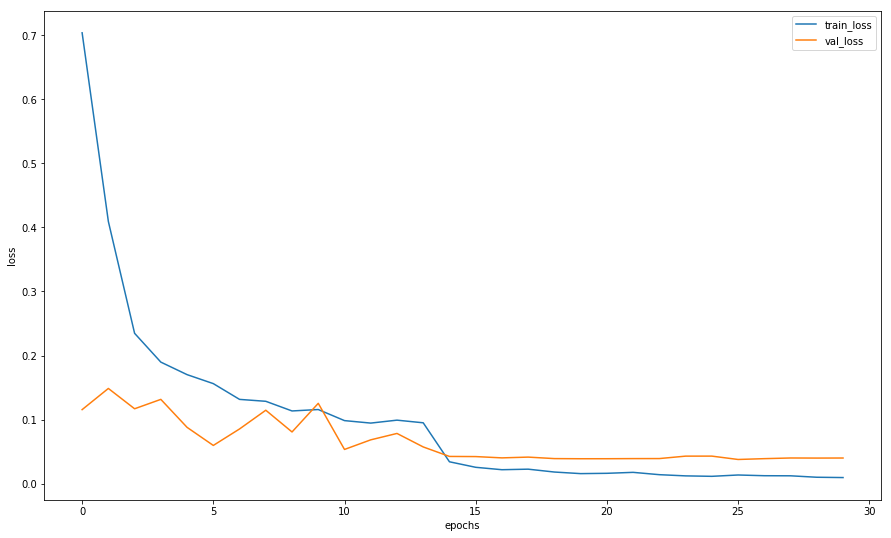

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Вычисляем целевыую метрику на валидационной выборке

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 50)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [i for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='macro')


1.0

Наш Submit

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
submit.to_csv('submission.csv', index=False)

Итого: F1 - 0.99681

